# Analysis of transactions

In [1]:
import pandas as pd
from datetime import datetime as dt
import functions

import matplotlib.pyplot as plt
plt.close('all')
# plt.style.use('dark_background')

import plotly.express as px
import plotly.io as pio
# pio.renderers.default = 'browser'

## user input

In [2]:
# forecast
next_months = 3

# column names
clm = dict(
    date       = 'date'      ,  # in transactions file
    amount     = 'amount'    ,  # in transactions file
    category   = 'category'  ,  # in transactions file
    balance    = 'balance'   ,  # in transactions file
    cat_fine   = 'type'      ,  # for fine categories
    sum        = 'SUM'       ,  # for result
    mean_month = '/MONTH'    ,  # for result
    mean_trsct = '/TRSACT'   ,  # for result
    )

## read & modify transactions
- load file

In [3]:
transactions = pd.read_csv('transactions.csv', sep =";", decimal='.', encoding = "ISO-8859-1")

# transactions[clm['date']] = pd.to_datetime(transactions[clm['date']], format='%d.%m.%Y')
transactions[clm['date']] = pd.to_datetime(transactions[clm['date']], format='%Y-%m-%d')

- split categories into rough and fine

In [4]:
transactions[ [ clm['category'] , clm['cat_fine'] ] ] = transactions[clm['category']].str.split('/', expand=True)

transactions[clm['cat_fine']].fillna(transactions[clm['category']], inplace=True)

- filter time

In [5]:
year = 2022
transactions = transactions.query('date.dt.year >= @year and date.dt.year < @year + 1')

# year = 2022
# month = 8
# transactions = transactions[ (transactions[clm['date']] >= dt(year,month,1)) & (transactions[clm['date']] < dt(year,month+1,1)) ]

# transactions = transactions[ transactions[clm['date']] >= dt.today() - relativedelta.relativedelta(years=1) ]

# transactions = transactions[ transactions[clm['date']] >= dt(2022,9,1) ]

- filter category

In [6]:
# transactions = transactions[~ transactions[clm['category']].isin(['vacation'])]

## table sum per month & category
- create table from transactions

In [7]:
sum_cat_month = functions.get_sum_cat_month(transactions, clm, next_months)

pd.options.display.float_format = '{:,.0f}'.format
print(sum_cat_month.fillna(0))

                 2022-01  2022-02  2022-03  2022-04  2022-05  2022-06  \
flat              -1,348   -1,076   -1,182   -1,195   -1,076   -1,076   
income             2,700    2,700    2,700    2,700    2,700    2,700   
leisure             -133        0     -424     -149     -416     -479   
living expenses     -519     -293     -839     -433     -526     -352   
mobility            -566     -187     -615   -1,409     -196     -286   
vacation               0        0        0        0     -295     -204   
SUM                  135    1,144     -360     -486      192      304   

                 2022-07  2022-08  2022-09  2022-10  2022-11  2022-12     SUM  \
flat              -1,118   -1,126   -1,093   -1,093   -1,093   -1,093 -13,567   
income             2,700    2,700    2,700    2,700    2,700    2,700  32,400   
leisure             -131     -412     -132     -292     -279     -180  -3,027   
living expenses     -401     -931     -257     -587     -175     -526  -5,839   
mobility  

- save table to excel

In [8]:
# result_name = ('overview_' + 
#                 str(min(transactions[clm['date']]))[:10] + '__' + 
#                 str(max(transactions[clm['date']]))[:10] )

# sum_cat_month.to_excel(result_name + '.xlsx')

## plot

- pie-chart all categories

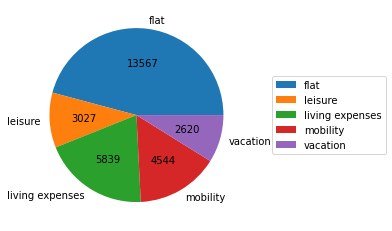

In [9]:
df_plot_pie = sum_cat_month[clm['sum']].drop(clm['sum']).pipe(lambda x: x[x<0]).abs().rename('')

df_plot_pie.plot.pie(autopct = lambda p: '{:.0f}'.format(p * df_plot_pie.sum() / 100) )
plt.legend(loc='center left', bbox_to_anchor=(1.1, 0.5))
plt.grid()
plt.show()

- sunburst all categories

In [10]:
df_sunburst = transactions.groupby([clm['cat_fine'] , clm['category']], as_index=False)
df_sunburst = df_sunburst.agg({clm['amount']: 'sum', clm['category']: 'first'})
df_sunburst = df_sunburst[ df_sunburst[clm['amount']] < 0]
df_sunburst[clm['amount']] = df_sunburst[clm['amount']].abs()

px.sunburst(df_sunburst, path=[clm['category'], clm['cat_fine']], values=clm['amount'] ).show()

- balance over time

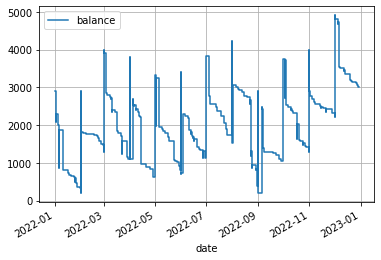

Balance: 2803.28 €


In [11]:
transactions.plot(clm['date'], clm['balance'], drawstyle='steps-post')
plt.grid()
plt.show()

balance = ( transactions.iloc[-1][clm['amount' ]]
          + transactions.iloc[ 0][clm['balance']]
          - transactions.iloc[-1][clm['balance']] )
print(f"Balance: { round( balance , 2) } €")

- dataframe for plots

In [12]:
df_plot = sum_cat_month.transpose().drop([ clm['sum'], clm['mean_month'], clm['mean_trsct'] ])

- all categories per month

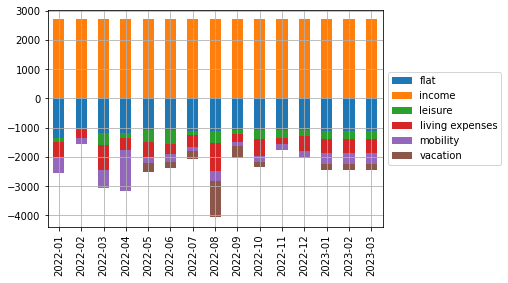

In [13]:
df_plot.drop([clm['sum']],axis=1).plot.bar(stacked=True)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.grid()
plt.show()

- saldo per month

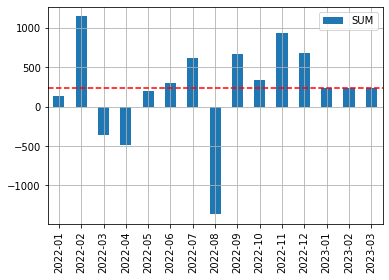

In [14]:
df_plot.plot.bar(y=clm['sum'])
plt.axhline(y=sum_cat_month[clm['mean_month']][clm['sum']], color='r', linestyle='--')
plt.grid()
plt.show()

- individual categories per month

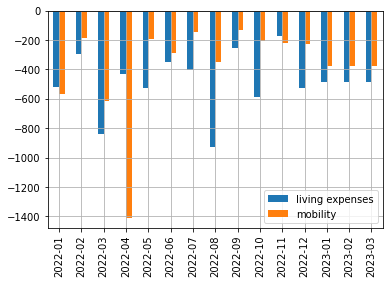

In [15]:
df_plot.plot.bar(y=['living expenses','mobility'])
plt.grid()
plt.show()